## ResNetV2

Il notebook addestra un classificatore utilizzando il modello predefinito di Keras ResNet50V2.

Sono state sperimentate due tecniche distinte:
1. Transfer Learning (a partire dal modello preaddestrato utilizzando ImageNet);
2. Addestramento classico del modello.

---

[Christian Szegedy, Sergey Ioffe, Vincent Vanhoucke, Alex Alemi - Inception-v4, Inception-ResNet and the Impact of Residual Connections on Learning](https://arxiv.org/pdf/1602.07261v2.pdf)

[Keras ResNet50V2](https://keras.io/api/applications/resnet/#resnet50v2-function)

[Keras Transfer Learning and Fine-Tuning](https://keras.io/guides/transfer_learning/)

### Import

In [ ]:
import os
from zipfile import ZipFile
from google.colab import drive

import cv2

from matplotlib import pyplot as plt

import numpy as np

from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras import Sequential
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.test import gpu_device_name

### Setup

In [ ]:
def check_gpu():
    device_name = gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))

if True:
    check_gpu()

Found GPU at: /device:GPU:0


In [ ]:
drive.mount('/content/dario')

with ZipFile(os.path.join(os.getcwd(), 'dario/MyDrive/vp/dataset.zip'), 'r') as zip_file:
    zip_file.extractall('data')

Mounted at /content/dario


### Configurazione

In [ ]:
classes = ['happy', 'sad', 'angry', 'disgust', 'fear', 'neutral', 'surprise']
labels = [i for i in range(len(classes))]
class_dict = dict(zip(labels, classes))

train_dir = 'data/train/'
max_examples = None

random_state = 42

### Caricamento dei dati

In [ ]:
examples = list()

for (label, path) in class_dict.items():
    current_dir = os.path.join(os.getcwd(), train_dir, path)
    i = 0
    for image_path in os.listdir(current_dir):
        if max_examples != None and i > max_examples:
            break
        image = cv2.cvtColor(cv2.imread(os.path.join(current_dir, image_path)), cv2.COLOR_BGR2RGB)
        examples.append((image, label))
        i += 1

### Visualizzazione dei dati

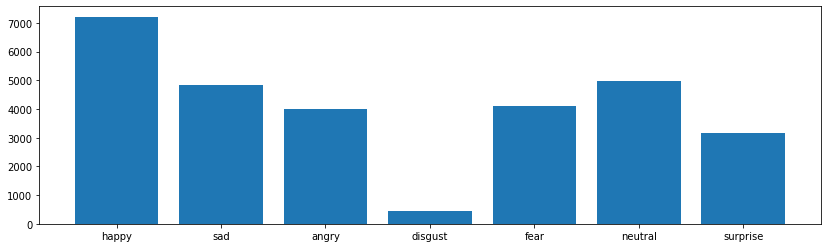

In [ ]:
example_stats = dict()

for example in examples:
    current_class = class_dict[example[1]]
    if not current_class in example_stats:
        example_stats[current_class] = 0
    example_stats[current_class] += 1

plt.figure(figsize=(2 * len(example_stats.items()), 4))
plt.bar(example_stats.keys(), example_stats.values())
plt.show()

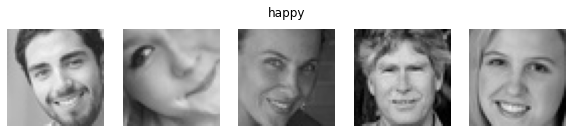

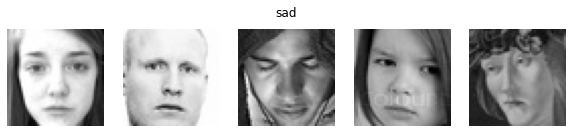

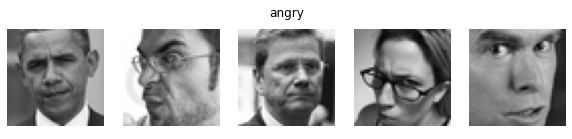

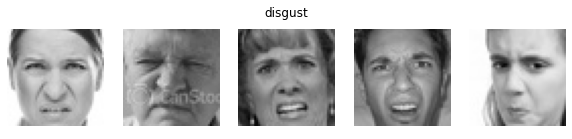

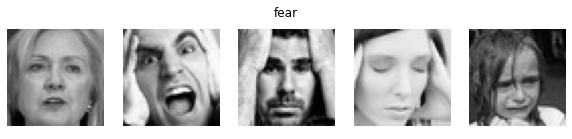

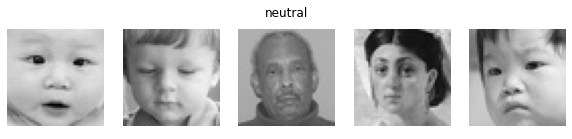

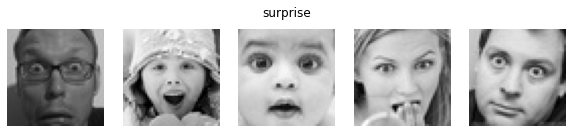

In [ ]:
previous_examples_amount = 0

for current_class in class_dict.items():
    figure = plt.figure(figsize=(10, 2))
    plt.title(current_class[1])
    plt.axis('off')

    n_examples = 5
    previous_examples_amount += example_stats[class_dict[current_class[0] - 1]] if current_class[0] > 0 else 0
    axes = figure.subplots(1, n_examples)
    for i in range(n_examples):
        axes[i].axis('off')
        axes[i].imshow(examples[i + previous_examples_amount][0], cmap='gray')

    plt.show()

### Modello

In [ ]:
class TransferLearningModel(Sequential):
    def __init__(self, base_model, num_classes):
        super().__init__()
        self.add(base_model)

        self.add(GlobalAveragePooling2D())

        self.add(Flatten())
        self.add(Dense(256, activation='relu'))
        self.add(BatchNormalization())
        self.add(Dropout(0.3))

        self.add(Dense(128, activation='relu'))
        self.add(BatchNormalization())
        self.add(Dropout(0.3))

        self.add(Dense(num_classes, activation="softmax"))

### Train, validation, test split

In [ ]:
X = []
y = []

for example in examples:
    X.append(example[0])
    y.append(example[1])

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)
X_val = preprocess_input(X_val)

### Data augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    shear_range=0.1,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.1,
    horizontal_flip=True)

val_datagen = ImageDataGenerator()

batch_size = 128
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val)

steps_per_epoch = train_generator.n // train_generator.batch_size
input_shape = X_train[0].shape

### Addestramento

In [ ]:
base_model = ResNet50V2(include_top=False, input_shape=input_shape, classes=len(classes), weights=None)

# Necessario solo nel caso di transfer learning
# for layer in base_model.layers[:-10]:
#     layer.trainable = False

model = TransferLearningModel(base_model, len(classes))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "transfer_learning_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)   

In [ ]:
n_epochs = 150

lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-10)
es = EarlyStopping(monitor='val_loss', verbose=1, patience=20)

history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=n_epochs,
        validation_data=val_generator,
        callbacks=[lr, es])

Epoch 1/150
120/120 [==============================] - 29s 174ms/step - loss: 2.1857 - accuracy: 0.1981 - val_loss: 1.8427 - val_accuracy: 0.2282 - lr: 0.0010
Epoch 2/150
120/120 [==============================] - 18s 149ms/step - loss: 1.9223 - accuracy: 0.2459 - val_loss: 1.7995 - val_accuracy: 0.2768 - lr: 0.0010
Epoch 3/150
120/120 [==============================] - 19s 155ms/step - loss: 1.8330 - accuracy: 0.2658 - val_loss: 1.7173 - val_accuracy: 0.2930 - lr: 0.0010
Epoch 4/150
120/120 [==============================] - 18s 151ms/step - loss: 1.7984 - accuracy: 0.2927 - val_loss: 2.3492 - val_accuracy: 0.2984 - lr: 0.0010
Epoch 5/150
120/120 [==============================] - 18s 149ms/step - loss: 1.7451 - accuracy: 0.3157 - val_loss: 1.8436 - val_accuracy: 0.3387 - lr: 0.0010
Epoch 6/150
120/120 [==============================] - 18s 150ms/step - loss: 1.6970 - accuracy: 0.3438 - val_loss: 1.6419 - val_accuracy: 0.3621 - lr: 0.0010
Epoch 7/150
120/120 [=========================

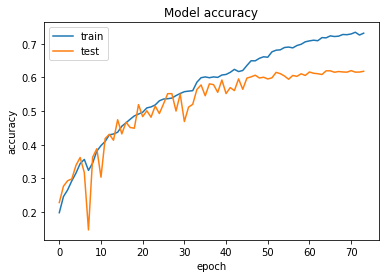

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')
plt.show()

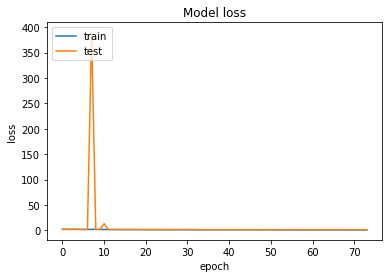

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')
plt.show()

297/297 [==============================] - 5s 13ms/step


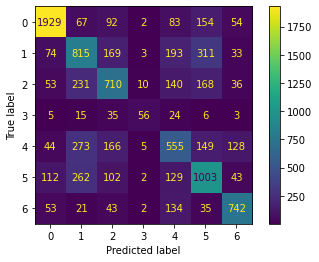

              precision    recall  f1-score   support

       happy       0.85      0.81      0.83      2381
         sad       0.48      0.51      0.50      1598
       angry       0.54      0.53      0.53      1348
     disgust       0.70      0.39      0.50       144
        fear       0.44      0.42      0.43      1320
     neutral       0.55      0.61      0.58      1653
    surprise       0.71      0.72      0.72      1030

    accuracy                           0.61      9474
   macro avg       0.61      0.57      0.58      9474
weighted avg       0.62      0.61      0.61      9474



In [ ]:
predictions = model.predict(X_test)
y_predicted = list(map(lambda p: np.argmax(p), predictions))

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_predicted))
disp.plot()
plt.show()

print(classification_report(y_test, y_predicted, target_names=classes))

### Salvataggio modello

In [ ]:
model.save('resnetv2')

%cp 'resnetv2' 'dario/MyDrive/vp' -r